In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchsummary import summary
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import numpy as np

# -----------------------------
# 1. Data Preprocessing
# -----------------------------
data_dir = "/kaggle/input/ju-cricket/Cricket_Dataset_final/Task_B"

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

train_ds = datasets.ImageFolder(f"{data_dir}/train/Bowling", transform=transform)
val_ds   = datasets.ImageFolder(f"{data_dir}/val/Bowling", transform=transform)
test_ds  = datasets.ImageFolder(f"{data_dir}/test/Bowling", transform=transform)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)

classes = train_ds.classes
print("Classes:", classes)



Classes: ['fast_bowl', 'spin_bowl']


In [2]:
print("Total training images:", len(train_ds))
print("Total validation images:", len(val_ds))
print("Total test images:", len(test_ds))

total_images = len(train_ds) + len(val_ds) + len(test_ds)
print("Total images in dataset:", total_images)


Total training images: 1710
Total validation images: 432
Total test images: 549
Total images in dataset: 2691


In [3]:
ignore_folder = "random_occlusion"

def count_images_ignore_folder(dataset, ignore_folder):
    count = 0
    for img_path, label in dataset.samples:
        # Skip if the image path contains the ignore_folder
        if ignore_folder not in img_path.split("/"):
            count += 1
    return count

train_count = count_images_ignore_folder(train_ds, ignore_folder)
val_count   = count_images_ignore_folder(val_ds, ignore_folder)
test_count  = count_images_ignore_folder(test_ds, ignore_folder)

total_count = train_count + val_count + test_count

print("Training images (excluding '{}'): {}".format(ignore_folder, train_count))
print("Validation images (excluding '{}'): {}".format(ignore_folder, val_count))
print("Test images (excluding '{}'): {}".format(ignore_folder, test_count))
print("Total images (excluding '{}'): {}".format(ignore_folder, total_count))


Training images (excluding 'random_occlusion'): 1520
Validation images (excluding 'random_occlusion'): 384
Test images (excluding 'random_occlusion'): 488
Total images (excluding 'random_occlusion'): 2392


In [4]:
ignore_folder = "random_occlusionw"

def get_included_folders(dataset, ignore_folder):
    included = set()
    for img_path, label in dataset.samples:
        # Split the path into parts and ignore if ignore_folder is in the path
        if ignore_folder not in img_path.split("/"):
            # The folder name just above the image (or the class folder)
            folder_name = img_path.split("/")[-2]
            included.add(folder_name)
    return included

train_folders = get_included_folders(train_ds, ignore_folder)
val_folders   = get_included_folders(val_ds, ignore_folder)
test_folders  = get_included_folders(test_ds, ignore_folder)

print("Training folders considered:", train_folders)
print("Validation folders considered:", val_folders)
print("Test folders considered:", test_folders)


Training folders considered: {'lens_flare', 'low_resolution', 'gaussian_noise', 'dirty_lens', 'blur', 'original', 'random_occlusion', 'motion_blur', 'chromatic_aberration'}
Validation folders considered: {'lens_flare', 'low_resolution', 'gaussian_noise', 'dirty_lens', 'blur', 'original', 'random_occlusion', 'motion_blur', 'chromatic_aberration'}
Test folders considered: {'lens_flare', 'low_resolution', 'gaussian_noise', 'dirty_lens', 'blur', 'original', 'random_occlusion', 'motion_blur', 'chromatic_aberration'}


In [5]:
ignore_folder = "random_occlusion"

def filter_samples(dataset, ignore_folder):
    # Keep only samples where ignore_folder is NOT in the path
    filtered_samples = [s for s in dataset.samples if ignore_folder not in s[0].split("/")]
    dataset.samples = filtered_samples
    dataset.targets = [s[1] for s in filtered_samples]  # Update targets accordingly
    return dataset

# Create original datasets
train_ds = datasets.ImageFolder(f"{data_dir}/train/Bowling", transform=transform)
val_ds   = datasets.ImageFolder(f"{data_dir}/val/Bowling", transform=transform)
test_ds  = datasets.ImageFolder(f"{data_dir}/test/Bowling", transform=transform)

# Filter out 'random_occlusion' folder
train_ds = filter_samples(train_ds, ignore_folder)
val_ds   = filter_samples(val_ds, ignore_folder)
test_ds  = filter_samples(test_ds, ignore_folder)

# DataLoaders
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)

# Classes (will remain the same)
classes = train_ds.classes
print("Classes:", classes)

# Show counts
print("Final Training images:", len(train_ds))
print("Final Validation images:", len(val_ds))
print("Final Test images:", len(test_ds))
print("Total images after filtering:", len(train_ds) + len(val_ds) + len(test_ds))


Classes: ['fast_bowl', 'spin_bowl']
Final Training images: 1520
Final Validation images: 384
Final Test images: 488
Total images after filtering: 2392


In [6]:
ignore_folder = "random_occlusion"

def get_included_folders(dataset, ignore_folder):
    included = set()
    for img_path, label in dataset.samples:
        # Split the path into parts and ignore if ignore_folder is in the path
        if ignore_folder not in img_path.split("/"):
            # The folder name just above the image (or the class folder)
            folder_name = img_path.split("/")[-2]
            included.add(folder_name)
    return included

train_folders = get_included_folders(train_ds, ignore_folder)
val_folders   = get_included_folders(val_ds, ignore_folder)
test_folders  = get_included_folders(test_ds, ignore_folder)

print("Training folders considered:", train_folders)
print("Validation folders considered:", val_folders)
print("Test folders considered:", test_folders)


Training folders considered: {'lens_flare', 'low_resolution', 'gaussian_noise', 'dirty_lens', 'blur', 'original', 'motion_blur', 'chromatic_aberration'}
Validation folders considered: {'lens_flare', 'low_resolution', 'gaussian_noise', 'dirty_lens', 'blur', 'original', 'motion_blur', 'chromatic_aberration'}
Test folders considered: {'lens_flare', 'low_resolution', 'gaussian_noise', 'dirty_lens', 'blur', 'original', 'motion_blur', 'chromatic_aberration'}


In [7]:


def _make_divisible(v, divisor, min_value=None):
    """
    This function is taken from the original tf repo.
    It ensures that all layers have a channel number that is divisible by 8
    """
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v

class Swish(nn.Module):
    """Swish activation function (x * sigmoid(x))"""
    def forward(self, x):
        return x * torch.sigmoid(x)

class SqueezeExcitation(nn.Module):
    """Squeeze-and-Excitation block"""
    def __init__(self, in_planes, reduced_dim):
        super().__init__()
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_planes, reduced_dim, 1),
            Swish(),
            nn.Conv2d(reduced_dim, in_planes, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return x * self.se(x)

class StochasticDepth(nn.Module):
    """Stochastic Depth regularization"""
    def __init__(self, drop_rate):
        super().__init__()
        self.drop_rate = drop_rate

    def forward(self, x, residual):
        if not self.training:
            return residual + x
        
        if self.drop_rate > 0:
            batch_size = x.shape[0]
            random_tensor = (1 - self.drop_rate) + torch.rand(
                (batch_size, 1, 1, 1), dtype=x.dtype, device=x.device
            )
            binary_mask = torch.floor(random_tensor)
            x = x / (1 - self.drop_rate) * binary_mask
        return residual + x

class MBConvBlock(nn.Module):
    """Mobile Inverted Residual Bottleneck Block"""
    def __init__(self, in_planes, out_planes, kernel_size, stride, expand_ratio, se_ratio, drop_rate):
        super().__init__()
        self.in_planes = in_planes
        self.out_planes = out_planes
        self.stride = stride
        self.expand_ratio = expand_ratio
        
        # Expansion phase
        hidden_dim = in_planes * expand_ratio
        self.expand_conv = nn.Conv2d(in_planes, hidden_dim, 1, bias=False) if expand_ratio != 1 else nn.Identity()
        self.expand_bn = nn.BatchNorm2d(hidden_dim) if expand_ratio != 1 else nn.Identity()
        
        # Depthwise convolution
        self.depthwise_conv = nn.Conv2d(hidden_dim, hidden_dim, kernel_size, stride, 
                                       padding=(kernel_size-1)//2, groups=hidden_dim, bias=False)
        self.depthwise_bn = nn.BatchNorm2d(hidden_dim)
        
        # Squeeze-and-Excitation
        se_planes = max(1, int(in_planes * se_ratio))
        self.se = SqueezeExcitation(hidden_dim, se_planes)
        
        # Output phase
        self.project_conv = nn.Conv2d(hidden_dim, out_planes, 1, bias=False)
        self.project_bn = nn.BatchNorm2d(out_planes)
        
        # Stochastic depth
        self.stoch_depth = StochasticDepth(drop_rate)
        
        # Skip connection
        self.use_skip_connection = (stride == 1) and (in_planes == out_planes)
        
    def forward(self, x):
        residual = x
        
        # Expansion
        if self.expand_ratio != 1:
            x = Swish()(self.expand_bn(self.expand_conv(x)))
        
        # Depthwise
        x = Swish()(self.depthwise_bn(self.depthwise_conv(x)))
        
        # Squeeze-and-Excitation
        x = self.se(x)
        
        # Project
        x = self.project_bn(self.project_conv(x))
        
        # Skip connection and stochastic depth
        if self.use_skip_connection:
            x = self.stoch_depth(x, residual)
        
        return x

class MyEfficientNetB0(nn.Module):
    """EfficientNetB0 Implementation from Scratch"""
    def __init__(self, num_classes=4, width_coeff=1.0, depth_coeff=1.0, dropout_rate=0.2, drop_connect_rate=0.2):
        super().__init__()
        
        # EfficientNet-B0 baseline
        # [expansion, output_filter, num_repeat, stride, kernel_size, se_ratio]
        settings = [
            [1,  16, 1, 1, 3, 0.25],  # MBConv1_3x3, SE, 112 -> 112
            [6,  24, 2, 2, 3, 0.25],  # MBConv6_3x3, SE, 112 ->  56
            [6,  40, 2, 2, 5, 0.25],  # MBConv6_5x5, SE,  56 ->  28
            [6,  80, 3, 2, 3, 0.25],  # MBConv6_3x3, SE,  28 ->  14
            [6, 112, 3, 1, 5, 0.25],  # MBConv6_5x5, SE,  14 ->  14
            [6, 192, 4, 2, 5, 0.25],  # MBConv6_5x5, SE,  14 ->   7
            [6, 320, 1, 1, 3, 0.25],  # MBConv6_3x3, SE,   7 ->   7
        ]
        
        # Stem
        out_channels = _make_divisible(32 * width_coeff, 8)
        self.stem_conv = nn.Conv2d(3, out_channels, 3, stride=2, padding=1, bias=False)
        self.stem_bn = nn.BatchNorm2d(out_channels)
        
        # Building inverted residual blocks
        self.blocks = nn.ModuleList([])
        in_channels = out_channels
        
        total_blocks = sum([max(1, int(math.ceil(num_repeat * depth_coeff))) for _, _, num_repeat, _, _, _ in settings])
        block_idx = 0
        
        for expand_ratio, output_filter, num_repeat, stride, kernel_size, se_ratio in settings:
            output_filter = _make_divisible(output_filter * width_coeff, 8)
            num_repeat = max(1, int(math.ceil(num_repeat * depth_coeff)))
            
            for i in range(num_repeat):
                drop_rate = drop_connect_rate * block_idx / total_blocks
                
                self.blocks.append(MBConvBlock(
                    in_channels if i == 0 else output_filter,
                    output_filter,
                    kernel_size,
                    stride if i == 0 else 1,
                    expand_ratio,
                    se_ratio,
                    drop_rate
                ))
                
                block_idx += 1
            in_channels = output_filter
        
        # Head
        self.head_conv = nn.Conv2d(in_channels, _make_divisible(1280 * width_coeff, 8), 1, bias=False)
        self.head_bn = nn.BatchNorm2d(_make_divisible(1280 * width_coeff, 8))
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(dropout_rate)
        self.classifier = nn.Linear(_make_divisible(1280 * width_coeff, 8), num_classes)
        
        # Initialize weights
        self._initialize_weights()
    
    def _initialize_weights(self):
        """Initialize weights using appropriate methods"""
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.zeros_(m.bias)
    
    def forward(self, x):
        # Stem
        x = Swish()(self.stem_bn(self.stem_conv(x)))
        
        # Blocks
        for block in self.blocks:
            x = block(x)
        
        # Head
        x = Swish()(self.head_bn(self.head_conv(x)))
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.classifier(x)
        
        return x

In [8]:
import math
# -----------------------------
# 3. Training Setup
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MyEfficientNetB0(num_classes=len(classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print("EfficientNetB0 Model Summary:")
try:
    summary(model, (3, 224, 224))
except:
    print("Model summary generation failed - this is normal for complex architectures")
    print(f"Model created successfully with {sum(p.numel() for p in model.parameters()):,} parameters")

EfficientNetB0 Model Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
            Conv2d-3         [-1, 32, 112, 112]             288
       BatchNorm2d-4         [-1, 32, 112, 112]              64
 AdaptiveAvgPool2d-5             [-1, 32, 1, 1]               0
            Conv2d-6              [-1, 8, 1, 1]             264
             Swish-7              [-1, 8, 1, 1]               0
            Conv2d-8             [-1, 32, 1, 1]             288
           Sigmoid-9             [-1, 32, 1, 1]               0
SqueezeExcitation-10         [-1, 32, 112, 112]               0
           Conv2d-11         [-1, 16, 112, 112]             512
      BatchNorm2d-12         [-1, 16, 112, 112]              32
      MBConvBlock-13         [-1, 16, 112, 112]               0
         


üöÄ Starting EfficientNetB0 Training for 50 epochs...

üìà Epoch 1/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:27<00:00,  1.76it/s, Loss=0.7000, Acc=0.5954]


‚úÖ Training completed in 27.32s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:04<00:00,  2.77it/s, Loss=0.6660, Acc=0.6250]


‚úÖ Validation completed in 4.35s
üåü New best EfficientNetB0 model found! Validation Accuracy: 0.6250

üìä Epoch 1 Summary:
‚îÇ Train Loss: 0.7000 | Train Acc: 0.5954
‚îÇ Val Loss:   0.6660 | Val Acc:   0.6250
‚îÇ Train Time: 27.32s | Val Time: 4.35s
‚îÇ Total Epoch Time: 31.86s
‚îÇ Best Val Acc: 0.6250 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 4.1GB

üìà Epoch 2/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:20<00:00,  2.34it/s, Loss=0.6864, Acc=0.6197]


‚úÖ Training completed in 20.55s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:02<00:00,  4.10it/s, Loss=2.9828, Acc=0.6250]


‚úÖ Validation completed in 2.93s

üìä Epoch 2 Summary:
‚îÇ Train Loss: 0.6864 | Train Acc: 0.6197
‚îÇ Val Loss:   2.9828 | Val Acc:   0.6250
‚îÇ Train Time: 20.55s | Val Time: 2.93s
‚îÇ Total Epoch Time: 23.49s
‚îÇ Best Val Acc: 0.6250 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 4.1GB

üìà Epoch 3/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:20<00:00,  2.33it/s, Loss=0.6716, Acc=0.6224]


‚úÖ Training completed in 20.64s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:02<00:00,  4.18it/s, Loss=1.1131, Acc=0.6250]


‚úÖ Validation completed in 2.88s

üìä Epoch 3 Summary:
‚îÇ Train Loss: 0.6716 | Train Acc: 0.6224
‚îÇ Val Loss:   1.1131 | Val Acc:   0.6250
‚îÇ Train Time: 20.64s | Val Time: 2.88s
‚îÇ Total Epoch Time: 23.52s
‚îÇ Best Val Acc: 0.6250 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 4.1GB

üìà Epoch 4/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:20<00:00,  2.30it/s, Loss=0.6787, Acc=0.6118]


‚úÖ Training completed in 20.91s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:02<00:00,  4.10it/s, Loss=0.7445, Acc=0.6224]


‚úÖ Validation completed in 2.93s

üìä Epoch 4 Summary:
‚îÇ Train Loss: 0.6787 | Train Acc: 0.6118
‚îÇ Val Loss:   0.7445 | Val Acc:   0.6224
‚îÇ Train Time: 20.91s | Val Time: 2.93s
‚îÇ Total Epoch Time: 23.85s
‚îÇ Best Val Acc: 0.6250 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 4.1GB

üìà Epoch 5/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:20<00:00,  2.29it/s, Loss=0.6709, Acc=0.6237]


‚úÖ Training completed in 20.97s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:02<00:00,  4.12it/s, Loss=0.7590, Acc=0.6302]


‚úÖ Validation completed in 2.92s
üåü New best EfficientNetB0 model found! Validation Accuracy: 0.6302

üìä Epoch 5 Summary:
‚îÇ Train Loss: 0.6709 | Train Acc: 0.6237
‚îÇ Val Loss:   0.7590 | Val Acc:   0.6302
‚îÇ Train Time: 20.97s | Val Time: 2.92s
‚îÇ Total Epoch Time: 23.90s
‚îÇ Best Val Acc: 0.6302 (Epoch 5)
‚îÇ GPU Memory: 0.1GB / 4.1GB

üìà Epoch 6/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:21<00:00,  2.28it/s, Loss=0.6540, Acc=0.6296]


‚úÖ Training completed in 21.08s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:02<00:00,  4.17it/s, Loss=0.6482, Acc=0.6250]


‚úÖ Validation completed in 2.89s

üìä Epoch 6 Summary:
‚îÇ Train Loss: 0.6540 | Train Acc: 0.6296
‚îÇ Val Loss:   0.6482 | Val Acc:   0.6250
‚îÇ Train Time: 21.08s | Val Time: 2.89s
‚îÇ Total Epoch Time: 23.98s
‚îÇ Best Val Acc: 0.6302 (Epoch 5)
‚îÇ GPU Memory: 0.1GB / 4.1GB

üìà Epoch 7/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:21<00:00,  2.27it/s, Loss=0.6475, Acc=0.6204]


‚úÖ Training completed in 21.11s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:02<00:00,  4.11it/s, Loss=0.6692, Acc=0.6250]


‚úÖ Validation completed in 2.93s

üìä Epoch 7 Summary:
‚îÇ Train Loss: 0.6475 | Train Acc: 0.6204
‚îÇ Val Loss:   0.6692 | Val Acc:   0.6250
‚îÇ Train Time: 21.11s | Val Time: 2.93s
‚îÇ Total Epoch Time: 24.04s
‚îÇ Best Val Acc: 0.6302 (Epoch 5)
‚îÇ GPU Memory: 0.1GB / 4.1GB

üìà Epoch 8/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:21<00:00,  2.23it/s, Loss=0.6388, Acc=0.6224]


‚úÖ Training completed in 21.49s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:02<00:00,  4.18it/s, Loss=0.6705, Acc=0.6224]


‚úÖ Validation completed in 2.87s

üìä Epoch 8 Summary:
‚îÇ Train Loss: 0.6388 | Train Acc: 0.6224
‚îÇ Val Loss:   0.6705 | Val Acc:   0.6224
‚îÇ Train Time: 21.49s | Val Time: 2.87s
‚îÇ Total Epoch Time: 24.37s
‚îÇ Best Val Acc: 0.6302 (Epoch 5)
‚îÇ GPU Memory: 0.1GB / 4.1GB

üìà Epoch 9/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:21<00:00,  2.25it/s, Loss=0.6227, Acc=0.6487]


‚úÖ Training completed in 21.38s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:02<00:00,  4.03it/s, Loss=0.7392, Acc=0.5417]


‚úÖ Validation completed in 2.99s

üìä Epoch 9 Summary:
‚îÇ Train Loss: 0.6227 | Train Acc: 0.6487
‚îÇ Val Loss:   0.7392 | Val Acc:   0.5417
‚îÇ Train Time: 21.38s | Val Time: 2.99s
‚îÇ Total Epoch Time: 24.37s
‚îÇ Best Val Acc: 0.6302 (Epoch 5)
‚îÇ GPU Memory: 0.1GB / 4.1GB

üìà Epoch 10/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:21<00:00,  2.26it/s, Loss=0.6086, Acc=0.6664]


‚úÖ Training completed in 21.22s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:03<00:00,  3.92it/s, Loss=0.6325, Acc=0.6745]


‚úÖ Validation completed in 3.07s
üåü New best EfficientNetB0 model found! Validation Accuracy: 0.6745

üìä Epoch 10 Summary:
‚îÇ Train Loss: 0.6086 | Train Acc: 0.6664
‚îÇ Val Loss:   0.6325 | Val Acc:   0.6745
‚îÇ Train Time: 21.22s | Val Time: 3.07s
‚îÇ Total Epoch Time: 24.30s
‚îÇ Best Val Acc: 0.6745 (Epoch 10)
‚îÇ GPU Memory: 0.1GB / 4.1GB

üìà Epoch 11/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:21<00:00,  2.25it/s, Loss=0.5799, Acc=0.6888]


‚úÖ Training completed in 21.31s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:02<00:00,  4.10it/s, Loss=0.7538, Acc=0.6406]


‚úÖ Validation completed in 2.93s

üìä Epoch 11 Summary:
‚îÇ Train Loss: 0.5799 | Train Acc: 0.6888
‚îÇ Val Loss:   0.7538 | Val Acc:   0.6406
‚îÇ Train Time: 21.31s | Val Time: 2.93s
‚îÇ Total Epoch Time: 24.25s
‚îÇ Best Val Acc: 0.6745 (Epoch 10)
‚îÇ GPU Memory: 0.1GB / 4.1GB

üìà Epoch 12/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:21<00:00,  2.25it/s, Loss=0.5533, Acc=0.7276]


‚úÖ Training completed in 21.34s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:02<00:00,  4.12it/s, Loss=0.7190, Acc=0.6693]


‚úÖ Validation completed in 2.92s

üìä Epoch 12 Summary:
‚îÇ Train Loss: 0.5533 | Train Acc: 0.7276
‚îÇ Val Loss:   0.7190 | Val Acc:   0.6693
‚îÇ Train Time: 21.34s | Val Time: 2.92s
‚îÇ Total Epoch Time: 24.26s
‚îÇ Best Val Acc: 0.6745 (Epoch 10)
‚îÇ GPU Memory: 0.1GB / 4.1GB

üìà Epoch 13/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:21<00:00,  2.27it/s, Loss=0.4496, Acc=0.7875]


‚úÖ Training completed in 21.18s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:02<00:00,  4.13it/s, Loss=0.7991, Acc=0.6979]


‚úÖ Validation completed in 2.92s
üåü New best EfficientNetB0 model found! Validation Accuracy: 0.6979

üìä Epoch 13 Summary:
‚îÇ Train Loss: 0.4496 | Train Acc: 0.7875
‚îÇ Val Loss:   0.7991 | Val Acc:   0.6979
‚îÇ Train Time: 21.18s | Val Time: 2.92s
‚îÇ Total Epoch Time: 24.10s
‚îÇ Best Val Acc: 0.6979 (Epoch 13)
‚îÇ GPU Memory: 0.1GB / 4.1GB

üìà Epoch 14/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:21<00:00,  2.26it/s, Loss=0.3695, Acc=0.8401]


‚úÖ Training completed in 21.22s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:02<00:00,  4.11it/s, Loss=1.2828, Acc=0.6120]


‚úÖ Validation completed in 2.93s

üìä Epoch 14 Summary:
‚îÇ Train Loss: 0.3695 | Train Acc: 0.8401
‚îÇ Val Loss:   1.2828 | Val Acc:   0.6120
‚îÇ Train Time: 21.22s | Val Time: 2.93s
‚îÇ Total Epoch Time: 24.15s
‚îÇ Best Val Acc: 0.6979 (Epoch 13)
‚îÇ GPU Memory: 0.1GB / 4.1GB

üìà Epoch 15/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:21<00:00,  2.26it/s, Loss=0.2976, Acc=0.8822]


‚úÖ Training completed in 21.20s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:02<00:00,  4.12it/s, Loss=0.8488, Acc=0.6562]


‚úÖ Validation completed in 2.92s

üìä Epoch 15 Summary:
‚îÇ Train Loss: 0.2976 | Train Acc: 0.8822
‚îÇ Val Loss:   0.8488 | Val Acc:   0.6562
‚îÇ Train Time: 21.20s | Val Time: 2.92s
‚îÇ Total Epoch Time: 24.12s
‚îÇ Best Val Acc: 0.6979 (Epoch 13)
‚îÇ GPU Memory: 0.1GB / 4.1GB

üìà Epoch 16/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:21<00:00,  2.25it/s, Loss=0.2491, Acc=0.9013]


‚úÖ Training completed in 21.31s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:02<00:00,  4.16it/s, Loss=1.0717, Acc=0.6198]


‚úÖ Validation completed in 2.89s

üìä Epoch 16 Summary:
‚îÇ Train Loss: 0.2491 | Train Acc: 0.9013
‚îÇ Val Loss:   1.0717 | Val Acc:   0.6198
‚îÇ Train Time: 21.31s | Val Time: 2.89s
‚îÇ Total Epoch Time: 24.21s
‚îÇ Best Val Acc: 0.6979 (Epoch 13)
‚îÇ GPU Memory: 0.1GB / 4.1GB

üìà Epoch 17/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:21<00:00,  2.27it/s, Loss=0.1641, Acc=0.9428]


‚úÖ Training completed in 21.16s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:02<00:00,  4.07it/s, Loss=1.7392, Acc=0.5547]


‚úÖ Validation completed in 2.96s

üìä Epoch 17 Summary:
‚îÇ Train Loss: 0.1641 | Train Acc: 0.9428
‚îÇ Val Loss:   1.7392 | Val Acc:   0.5547
‚îÇ Train Time: 21.16s | Val Time: 2.96s
‚îÇ Total Epoch Time: 24.12s
‚îÇ Best Val Acc: 0.6979 (Epoch 13)
‚îÇ GPU Memory: 0.1GB / 4.1GB

üìà Epoch 18/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:21<00:00,  2.25it/s, Loss=0.1507, Acc=0.9441]


‚úÖ Training completed in 21.34s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:02<00:00,  4.10it/s, Loss=1.4152, Acc=0.6380]


‚úÖ Validation completed in 2.94s

üìä Epoch 18 Summary:
‚îÇ Train Loss: 0.1507 | Train Acc: 0.9441
‚îÇ Val Loss:   1.4152 | Val Acc:   0.6380
‚îÇ Train Time: 21.34s | Val Time: 2.94s
‚îÇ Total Epoch Time: 24.28s
‚îÇ Best Val Acc: 0.6979 (Epoch 13)
‚îÇ GPU Memory: 0.1GB / 4.1GB

üìà Epoch 19/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:21<00:00,  2.24it/s, Loss=0.1093, Acc=0.9651]


‚úÖ Training completed in 21.48s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:02<00:00,  4.24it/s, Loss=1.3189, Acc=0.6823]


‚úÖ Validation completed in 2.84s

üìä Epoch 19 Summary:
‚îÇ Train Loss: 0.1093 | Train Acc: 0.9651
‚îÇ Val Loss:   1.3189 | Val Acc:   0.6823
‚îÇ Train Time: 21.48s | Val Time: 2.84s
‚îÇ Total Epoch Time: 24.32s
‚îÇ Best Val Acc: 0.6979 (Epoch 13)
‚îÇ GPU Memory: 0.1GB / 4.1GB

üìà Epoch 20/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:21<00:00,  2.26it/s, Loss=0.0975, Acc=0.9651]


‚úÖ Training completed in 21.20s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:02<00:00,  4.12it/s, Loss=1.1596, Acc=0.7135]


‚úÖ Validation completed in 2.92s
üåü New best EfficientNetB0 model found! Validation Accuracy: 0.7135

üìä Epoch 20 Summary:
‚îÇ Train Loss: 0.0975 | Train Acc: 0.9651
‚îÇ Val Loss:   1.1596 | Val Acc:   0.7135
‚îÇ Train Time: 21.20s | Val Time: 2.92s
‚îÇ Total Epoch Time: 24.13s
‚îÇ Best Val Acc: 0.7135 (Epoch 20)
‚îÇ GPU Memory: 0.1GB / 4.1GB

üìà Epoch 21/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:21<00:00,  2.25it/s, Loss=0.0994, Acc=0.9717]


‚úÖ Training completed in 21.31s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:02<00:00,  4.16it/s, Loss=1.3562, Acc=0.6745]


‚úÖ Validation completed in 2.89s

üìä Epoch 21 Summary:
‚îÇ Train Loss: 0.0994 | Train Acc: 0.9717
‚îÇ Val Loss:   1.3562 | Val Acc:   0.6745
‚îÇ Train Time: 21.31s | Val Time: 2.89s
‚îÇ Total Epoch Time: 24.21s
‚îÇ Best Val Acc: 0.7135 (Epoch 20)
‚îÇ GPU Memory: 0.1GB / 4.1GB

üìà Epoch 22/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:21<00:00,  2.27it/s, Loss=0.0671, Acc=0.9809]


‚úÖ Training completed in 21.14s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:02<00:00,  4.23it/s, Loss=1.3768, Acc=0.7031]


‚úÖ Validation completed in 2.85s

üìä Epoch 22 Summary:
‚îÇ Train Loss: 0.0671 | Train Acc: 0.9809
‚îÇ Val Loss:   1.3768 | Val Acc:   0.7031
‚îÇ Train Time: 21.14s | Val Time: 2.85s
‚îÇ Total Epoch Time: 24.00s
‚îÇ Best Val Acc: 0.7135 (Epoch 20)
‚îÇ GPU Memory: 0.1GB / 4.1GB

üìà Epoch 23/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:21<00:00,  2.27it/s, Loss=0.0768, Acc=0.9750]


‚úÖ Training completed in 21.17s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:02<00:00,  4.09it/s, Loss=1.6013, Acc=0.6172]


‚úÖ Validation completed in 2.94s

üìä Epoch 23 Summary:
‚îÇ Train Loss: 0.0768 | Train Acc: 0.9750
‚îÇ Val Loss:   1.6013 | Val Acc:   0.6172
‚îÇ Train Time: 21.17s | Val Time: 2.94s
‚îÇ Total Epoch Time: 24.10s
‚îÇ Best Val Acc: 0.7135 (Epoch 20)
‚îÇ GPU Memory: 0.1GB / 4.1GB

üìà Epoch 24/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:21<00:00,  2.23it/s, Loss=0.0646, Acc=0.9783]


‚úÖ Training completed in 21.48s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:02<00:00,  4.22it/s, Loss=1.4965, Acc=0.6667]


‚úÖ Validation completed in 2.85s

üìä Epoch 24 Summary:
‚îÇ Train Loss: 0.0646 | Train Acc: 0.9783
‚îÇ Val Loss:   1.4965 | Val Acc:   0.6667
‚îÇ Train Time: 21.48s | Val Time: 2.85s
‚îÇ Total Epoch Time: 24.34s
‚îÇ Best Val Acc: 0.7135 (Epoch 20)
‚îÇ GPU Memory: 0.1GB / 4.1GB

üìà Epoch 25/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:21<00:00,  2.25it/s, Loss=0.0417, Acc=0.9868]


‚úÖ Training completed in 21.30s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:03<00:00,  3.75it/s, Loss=1.4856, Acc=0.6797]


‚úÖ Validation completed in 3.21s

üìä Epoch 25 Summary:
‚îÇ Train Loss: 0.0417 | Train Acc: 0.9868
‚îÇ Val Loss:   1.4856 | Val Acc:   0.6797
‚îÇ Train Time: 21.30s | Val Time: 3.21s
‚îÇ Total Epoch Time: 24.51s
‚îÇ Best Val Acc: 0.7135 (Epoch 20)
‚îÇ GPU Memory: 0.1GB / 4.1GB

üìà Epoch 26/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:22<00:00,  2.14it/s, Loss=0.0386, Acc=0.9882]


‚úÖ Training completed in 22.40s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:03<00:00,  3.42it/s, Loss=1.6302, Acc=0.6250]


‚úÖ Validation completed in 3.51s

üìä Epoch 26 Summary:
‚îÇ Train Loss: 0.0386 | Train Acc: 0.9882
‚îÇ Val Loss:   1.6302 | Val Acc:   0.6250
‚îÇ Train Time: 22.40s | Val Time: 3.51s
‚îÇ Total Epoch Time: 25.92s
‚îÇ Best Val Acc: 0.7135 (Epoch 20)
‚îÇ GPU Memory: 0.1GB / 4.1GB

üìà Epoch 27/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:21<00:00,  2.20it/s, Loss=0.0455, Acc=0.9836]


‚úÖ Training completed in 21.87s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:02<00:00,  4.13it/s, Loss=1.2818, Acc=0.7005]


‚úÖ Validation completed in 2.91s

üìä Epoch 27 Summary:
‚îÇ Train Loss: 0.0455 | Train Acc: 0.9836
‚îÇ Val Loss:   1.2818 | Val Acc:   0.7005
‚îÇ Train Time: 21.87s | Val Time: 2.91s
‚îÇ Total Epoch Time: 24.78s
‚îÇ Best Val Acc: 0.7135 (Epoch 20)
‚îÇ GPU Memory: 0.1GB / 4.1GB

üìà Epoch 28/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:21<00:00,  2.26it/s, Loss=0.0335, Acc=0.9875]


‚úÖ Training completed in 21.23s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:02<00:00,  4.04it/s, Loss=1.8482, Acc=0.7109]


‚úÖ Validation completed in 2.98s

üìä Epoch 28 Summary:
‚îÇ Train Loss: 0.0335 | Train Acc: 0.9875
‚îÇ Val Loss:   1.8482 | Val Acc:   0.7109
‚îÇ Train Time: 21.23s | Val Time: 2.98s
‚îÇ Total Epoch Time: 24.21s
‚îÇ Best Val Acc: 0.7135 (Epoch 20)
‚îÇ GPU Memory: 0.1GB / 4.1GB

üìà Epoch 29/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:21<00:00,  2.24it/s, Loss=0.0225, Acc=0.9921]


‚úÖ Training completed in 21.39s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:02<00:00,  4.23it/s, Loss=2.0107, Acc=0.6797]


‚úÖ Validation completed in 2.84s

üìä Epoch 29 Summary:
‚îÇ Train Loss: 0.0225 | Train Acc: 0.9921
‚îÇ Val Loss:   2.0107 | Val Acc:   0.6797
‚îÇ Train Time: 21.39s | Val Time: 2.84s
‚îÇ Total Epoch Time: 24.24s
‚îÇ Best Val Acc: 0.7135 (Epoch 20)
‚îÇ GPU Memory: 0.1GB / 4.1GB

üìà Epoch 30/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:21<00:00,  2.28it/s, Loss=0.0426, Acc=0.9875]


‚úÖ Training completed in 21.08s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:02<00:00,  4.17it/s, Loss=1.3645, Acc=0.6953]


‚úÖ Validation completed in 2.88s

üìä Epoch 30 Summary:
‚îÇ Train Loss: 0.0426 | Train Acc: 0.9875
‚îÇ Val Loss:   1.3645 | Val Acc:   0.6953
‚îÇ Train Time: 21.08s | Val Time: 2.88s
‚îÇ Total Epoch Time: 23.96s
‚îÇ Best Val Acc: 0.7135 (Epoch 20)
‚îÇ GPU Memory: 0.1GB / 4.1GB

üìà Epoch 31/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:21<00:00,  2.26it/s, Loss=0.0334, Acc=0.9888]


‚úÖ Training completed in 21.28s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:02<00:00,  4.15it/s, Loss=1.7158, Acc=0.6536]


‚úÖ Validation completed in 2.90s

üìä Epoch 31 Summary:
‚îÇ Train Loss: 0.0334 | Train Acc: 0.9888
‚îÇ Val Loss:   1.7158 | Val Acc:   0.6536
‚îÇ Train Time: 21.28s | Val Time: 2.90s
‚îÇ Total Epoch Time: 24.19s
‚îÇ Best Val Acc: 0.7135 (Epoch 20)
‚îÇ GPU Memory: 0.1GB / 4.1GB

üìà Epoch 32/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:21<00:00,  2.27it/s, Loss=0.0341, Acc=0.9908]


‚úÖ Training completed in 21.14s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:02<00:00,  4.05it/s, Loss=2.0058, Acc=0.6484]


‚úÖ Validation completed in 2.97s

üìä Epoch 32 Summary:
‚îÇ Train Loss: 0.0341 | Train Acc: 0.9908
‚îÇ Val Loss:   2.0058 | Val Acc:   0.6484
‚îÇ Train Time: 21.14s | Val Time: 2.97s
‚îÇ Total Epoch Time: 24.12s
‚îÇ Best Val Acc: 0.7135 (Epoch 20)
‚îÇ GPU Memory: 0.1GB / 4.1GB

üìà Epoch 33/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:21<00:00,  2.23it/s, Loss=0.0296, Acc=0.9928]


‚úÖ Training completed in 21.50s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:02<00:00,  4.02it/s, Loss=2.0393, Acc=0.6484]


‚úÖ Validation completed in 2.99s

üìä Epoch 33 Summary:
‚îÇ Train Loss: 0.0296 | Train Acc: 0.9928
‚îÇ Val Loss:   2.0393 | Val Acc:   0.6484
‚îÇ Train Time: 21.50s | Val Time: 2.99s
‚îÇ Total Epoch Time: 24.50s
‚îÇ Best Val Acc: 0.7135 (Epoch 20)
‚îÇ GPU Memory: 0.1GB / 4.1GB

üìà Epoch 34/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:21<00:00,  2.24it/s, Loss=0.0234, Acc=0.9928]


‚úÖ Training completed in 21.38s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:02<00:00,  4.25it/s, Loss=1.4159, Acc=0.6719]


‚úÖ Validation completed in 2.83s

üìä Epoch 34 Summary:
‚îÇ Train Loss: 0.0234 | Train Acc: 0.9928
‚îÇ Val Loss:   1.4159 | Val Acc:   0.6719
‚îÇ Train Time: 21.38s | Val Time: 2.83s
‚îÇ Total Epoch Time: 24.22s
‚îÇ Best Val Acc: 0.7135 (Epoch 20)
‚îÇ GPU Memory: 0.1GB / 4.1GB

üìà Epoch 35/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:21<00:00,  2.27it/s, Loss=0.0258, Acc=0.9934]


‚úÖ Training completed in 21.11s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:02<00:00,  4.20it/s, Loss=1.6048, Acc=0.6953]


‚úÖ Validation completed in 2.86s

üìä Epoch 35 Summary:
‚îÇ Train Loss: 0.0258 | Train Acc: 0.9934
‚îÇ Val Loss:   1.6048 | Val Acc:   0.6953
‚îÇ Train Time: 21.11s | Val Time: 2.86s
‚îÇ Total Epoch Time: 23.98s
‚îÇ Best Val Acc: 0.7135 (Epoch 20)
‚îÇ GPU Memory: 0.1GB / 4.1GB

üìà Epoch 36/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:21<00:00,  2.27it/s, Loss=0.0100, Acc=0.9967]


‚úÖ Training completed in 21.14s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:02<00:00,  4.28it/s, Loss=1.8114, Acc=0.6849]


‚úÖ Validation completed in 2.81s

üìä Epoch 36 Summary:
‚îÇ Train Loss: 0.0100 | Train Acc: 0.9967
‚îÇ Val Loss:   1.8114 | Val Acc:   0.6849
‚îÇ Train Time: 21.14s | Val Time: 2.81s
‚îÇ Total Epoch Time: 23.95s
‚îÇ Best Val Acc: 0.7135 (Epoch 20)
‚îÇ GPU Memory: 0.1GB / 4.1GB

üìà Epoch 37/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:21<00:00,  2.28it/s, Loss=0.0026, Acc=0.9987]


‚úÖ Training completed in 21.04s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:02<00:00,  4.13it/s, Loss=1.6581, Acc=0.7240]


‚úÖ Validation completed in 2.92s
üåü New best EfficientNetB0 model found! Validation Accuracy: 0.7240

üìä Epoch 37 Summary:
‚îÇ Train Loss: 0.0026 | Train Acc: 0.9987
‚îÇ Val Loss:   1.6581 | Val Acc:   0.7240
‚îÇ Train Time: 21.04s | Val Time: 2.92s
‚îÇ Total Epoch Time: 23.96s
‚îÇ Best Val Acc: 0.7240 (Epoch 37)
‚îÇ GPU Memory: 0.1GB / 4.1GB

üìà Epoch 38/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:21<00:00,  2.24it/s, Loss=0.0358, Acc=0.9875]


‚úÖ Training completed in 21.39s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:02<00:00,  4.00it/s, Loss=1.9188, Acc=0.7318]


‚úÖ Validation completed in 3.00s
üåü New best EfficientNetB0 model found! Validation Accuracy: 0.7318

üìä Epoch 38 Summary:
‚îÇ Train Loss: 0.0358 | Train Acc: 0.9875
‚îÇ Val Loss:   1.9188 | Val Acc:   0.7318
‚îÇ Train Time: 21.39s | Val Time: 3.00s
‚îÇ Total Epoch Time: 24.40s
‚îÇ Best Val Acc: 0.7318 (Epoch 38)
‚îÇ GPU Memory: 0.1GB / 4.1GB

üìà Epoch 39/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:21<00:00,  2.22it/s, Loss=0.0342, Acc=0.9862]


‚úÖ Training completed in 21.62s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:03<00:00,  3.88it/s, Loss=1.6957, Acc=0.6797]


‚úÖ Validation completed in 3.10s

üìä Epoch 39 Summary:
‚îÇ Train Loss: 0.0342 | Train Acc: 0.9862
‚îÇ Val Loss:   1.6957 | Val Acc:   0.6797
‚îÇ Train Time: 21.62s | Val Time: 3.10s
‚îÇ Total Epoch Time: 24.73s
‚îÇ Best Val Acc: 0.7318 (Epoch 38)
‚îÇ GPU Memory: 0.1GB / 4.1GB

üìà Epoch 40/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:21<00:00,  2.27it/s, Loss=0.0598, Acc=0.9849]


‚úÖ Training completed in 21.18s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:02<00:00,  4.17it/s, Loss=1.3670, Acc=0.7057]


‚úÖ Validation completed in 2.88s

üìä Epoch 40 Summary:
‚îÇ Train Loss: 0.0598 | Train Acc: 0.9849
‚îÇ Val Loss:   1.3670 | Val Acc:   0.7057
‚îÇ Train Time: 21.18s | Val Time: 2.88s
‚îÇ Total Epoch Time: 24.06s
‚îÇ Best Val Acc: 0.7318 (Epoch 38)
‚îÇ GPU Memory: 0.1GB / 4.1GB

üìà Epoch 41/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:21<00:00,  2.25it/s, Loss=0.0347, Acc=0.9875]


‚úÖ Training completed in 21.38s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:02<00:00,  4.23it/s, Loss=1.7844, Acc=0.6875]


‚úÖ Validation completed in 2.85s

üìä Epoch 41 Summary:
‚îÇ Train Loss: 0.0347 | Train Acc: 0.9875
‚îÇ Val Loss:   1.7844 | Val Acc:   0.6875
‚îÇ Train Time: 21.38s | Val Time: 2.85s
‚îÇ Total Epoch Time: 24.23s
‚îÇ Best Val Acc: 0.7318 (Epoch 38)
‚îÇ GPU Memory: 0.1GB / 4.1GB

üìà Epoch 42/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:21<00:00,  2.26it/s, Loss=0.0353, Acc=0.9868]


‚úÖ Training completed in 21.20s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:02<00:00,  4.17it/s, Loss=1.7003, Acc=0.6901]


‚úÖ Validation completed in 2.89s

üìä Epoch 42 Summary:
‚îÇ Train Loss: 0.0353 | Train Acc: 0.9868
‚îÇ Val Loss:   1.7003 | Val Acc:   0.6901
‚îÇ Train Time: 21.20s | Val Time: 2.89s
‚îÇ Total Epoch Time: 24.09s
‚îÇ Best Val Acc: 0.7318 (Epoch 38)
‚îÇ GPU Memory: 0.1GB / 4.1GB

üìà Epoch 43/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:21<00:00,  2.27it/s, Loss=0.0156, Acc=0.9947]


‚úÖ Training completed in 21.17s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:02<00:00,  4.08it/s, Loss=1.9246, Acc=0.7057]


‚úÖ Validation completed in 2.94s

üìä Epoch 43 Summary:
‚îÇ Train Loss: 0.0156 | Train Acc: 0.9947
‚îÇ Val Loss:   1.9246 | Val Acc:   0.7057
‚îÇ Train Time: 21.17s | Val Time: 2.94s
‚îÇ Total Epoch Time: 24.12s
‚îÇ Best Val Acc: 0.7318 (Epoch 38)
‚îÇ GPU Memory: 0.1GB / 4.1GB

üìà Epoch 44/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:21<00:00,  2.25it/s, Loss=0.0223, Acc=0.9941]


‚úÖ Training completed in 21.29s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:02<00:00,  4.12it/s, Loss=1.6711, Acc=0.6797]


‚úÖ Validation completed in 2.92s

üìä Epoch 44 Summary:
‚îÇ Train Loss: 0.0223 | Train Acc: 0.9941
‚îÇ Val Loss:   1.6711 | Val Acc:   0.6797
‚îÇ Train Time: 21.29s | Val Time: 2.92s
‚îÇ Total Epoch Time: 24.22s
‚îÇ Best Val Acc: 0.7318 (Epoch 38)
‚îÇ GPU Memory: 0.1GB / 4.1GB

üìà Epoch 45/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:21<00:00,  2.26it/s, Loss=0.0164, Acc=0.9947]


‚úÖ Training completed in 21.27s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:02<00:00,  4.15it/s, Loss=2.0064, Acc=0.7031]


‚úÖ Validation completed in 2.90s

üìä Epoch 45 Summary:
‚îÇ Train Loss: 0.0164 | Train Acc: 0.9947
‚îÇ Val Loss:   2.0064 | Val Acc:   0.7031
‚îÇ Train Time: 21.27s | Val Time: 2.90s
‚îÇ Total Epoch Time: 24.17s
‚îÇ Best Val Acc: 0.7318 (Epoch 38)
‚îÇ GPU Memory: 0.1GB / 4.1GB

üìà Epoch 46/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:21<00:00,  2.28it/s, Loss=0.0145, Acc=0.9947]


‚úÖ Training completed in 21.08s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:02<00:00,  4.22it/s, Loss=2.1968, Acc=0.6927]


‚úÖ Validation completed in 2.85s

üìä Epoch 46 Summary:
‚îÇ Train Loss: 0.0145 | Train Acc: 0.9947
‚îÇ Val Loss:   2.1968 | Val Acc:   0.6927
‚îÇ Train Time: 21.08s | Val Time: 2.85s
‚îÇ Total Epoch Time: 23.94s
‚îÇ Best Val Acc: 0.7318 (Epoch 38)
‚îÇ GPU Memory: 0.1GB / 4.1GB

üìà Epoch 47/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:21<00:00,  2.24it/s, Loss=0.0071, Acc=0.9974]


‚úÖ Training completed in 21.48s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:02<00:00,  4.14it/s, Loss=2.3315, Acc=0.6641]


‚úÖ Validation completed in 2.90s

üìä Epoch 47 Summary:
‚îÇ Train Loss: 0.0071 | Train Acc: 0.9974
‚îÇ Val Loss:   2.3315 | Val Acc:   0.6641
‚îÇ Train Time: 21.48s | Val Time: 2.90s
‚îÇ Total Epoch Time: 24.38s
‚îÇ Best Val Acc: 0.7318 (Epoch 38)
‚îÇ GPU Memory: 0.1GB / 4.1GB

üìà Epoch 48/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:21<00:00,  2.25it/s, Loss=0.0076, Acc=0.9980]


‚úÖ Training completed in 21.34s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:03<00:00,  3.86it/s, Loss=2.6465, Acc=0.6406]


‚úÖ Validation completed in 3.11s

üìä Epoch 48 Summary:
‚îÇ Train Loss: 0.0076 | Train Acc: 0.9980
‚îÇ Val Loss:   2.6465 | Val Acc:   0.6406
‚îÇ Train Time: 21.34s | Val Time: 3.11s
‚îÇ Total Epoch Time: 24.46s
‚îÇ Best Val Acc: 0.7318 (Epoch 38)
‚îÇ GPU Memory: 0.1GB / 4.1GB

üìà Epoch 49/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:21<00:00,  2.26it/s, Loss=0.0349, Acc=0.9908]


‚úÖ Training completed in 21.21s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:02<00:00,  4.26it/s, Loss=1.4554, Acc=0.6849]


‚úÖ Validation completed in 2.83s

üìä Epoch 49 Summary:
‚îÇ Train Loss: 0.0349 | Train Acc: 0.9908
‚îÇ Val Loss:   1.4554 | Val Acc:   0.6849
‚îÇ Train Time: 21.21s | Val Time: 2.83s
‚îÇ Total Epoch Time: 24.05s
‚îÇ Best Val Acc: 0.7318 (Epoch 38)
‚îÇ GPU Memory: 0.1GB / 4.1GB

üìà Epoch 50/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:21<00:00,  2.27it/s, Loss=0.0201, Acc=0.9954]


‚úÖ Training completed in 21.19s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:02<00:00,  4.13it/s, Loss=1.7961, Acc=0.6849]


‚úÖ Validation completed in 2.91s

üìä Epoch 50 Summary:
‚îÇ Train Loss: 0.0201 | Train Acc: 0.9954
‚îÇ Val Loss:   1.7961 | Val Acc:   0.6849
‚îÇ Train Time: 21.19s | Val Time: 2.91s
‚îÇ Total Epoch Time: 24.10s
‚îÇ Best Val Acc: 0.7318 (Epoch 38)
‚îÇ GPU Memory: 0.1GB / 4.1GB

üíæ Best EfficientNetB0 model saved as 'best_efficientnetb0_model.pth'
üìä Best model stats:
‚îÇ Best Epoch: 38
‚îÇ Best Val Acc: 0.7318

üíæ EfficientNetB0 training history saved to 'efficientnetb0_training_history.csv'

üéâ EfficientNetB0 Training Complete!
Total Training Time: 1217.78s (20.3 minutes)
Average Epoch Time: 24.36s

‚è±Ô∏è  Epoch Timing Breakdown:
‚îÇ Epoch 1: 31.86s
‚îÇ Epoch 2: 23.49s
‚îÇ Epoch 3: 23.52s
‚îÇ Epoch 4: 23.85s
‚îÇ Epoch 5: 23.90s
‚îÇ Epoch 6: 23.98s
‚îÇ Epoch 7: 24.04s
‚îÇ Epoch 8: 24.37s
‚îÇ Epoch 9: 24.37s
‚îÇ Epoch 10: 24.30s
‚îÇ Epoch 11: 24.25s
‚îÇ Epoch 12: 24.26s
‚îÇ Epoch 13: 24.10s
‚îÇ Epoch 14: 24.15s
‚îÇ Epoch 15: 24.12s
‚îÇ Epoch 16: 24.21s
‚îÇ Epoch 17: 24.12s
‚î

Testing EfficientNetB0: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 16/16 [00:05<00:00,  2.73it/s]


‚úÖ EfficientNetB0 Testing completed in 5.86s

üìã EfficientNetB0 Classification Report:
              precision    recall  f1-score   support

   fast_bowl       0.72      0.69      0.70       304
   spin_bowl       0.52      0.55      0.53       184

    accuracy                           0.64       488
   macro avg       0.62      0.62      0.62       488
weighted avg       0.64      0.64      0.64       488

üéØ EfficientNetB0 Test Accuracy: 0.6352

üìä EfficientNetB0 Model Performance Summary:
‚îÇ Best Validation Acc:  0.7318 (Epoch 38)
‚îÇ Final Test Accuracy:  0.6352
‚îÇ Val-Test Gap:         0.0965


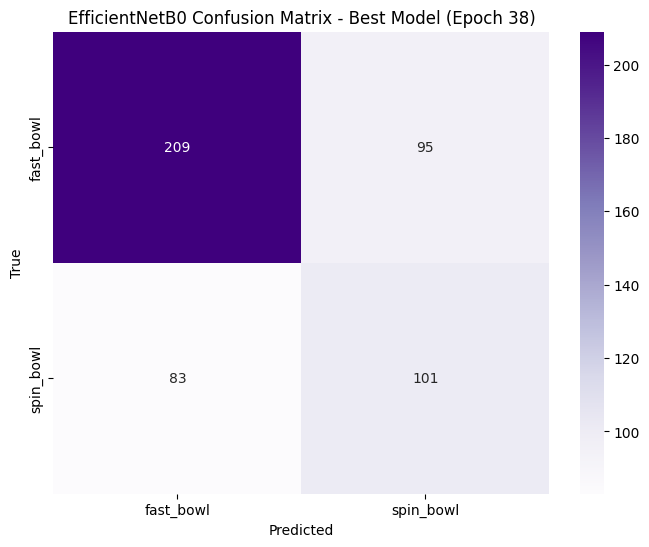

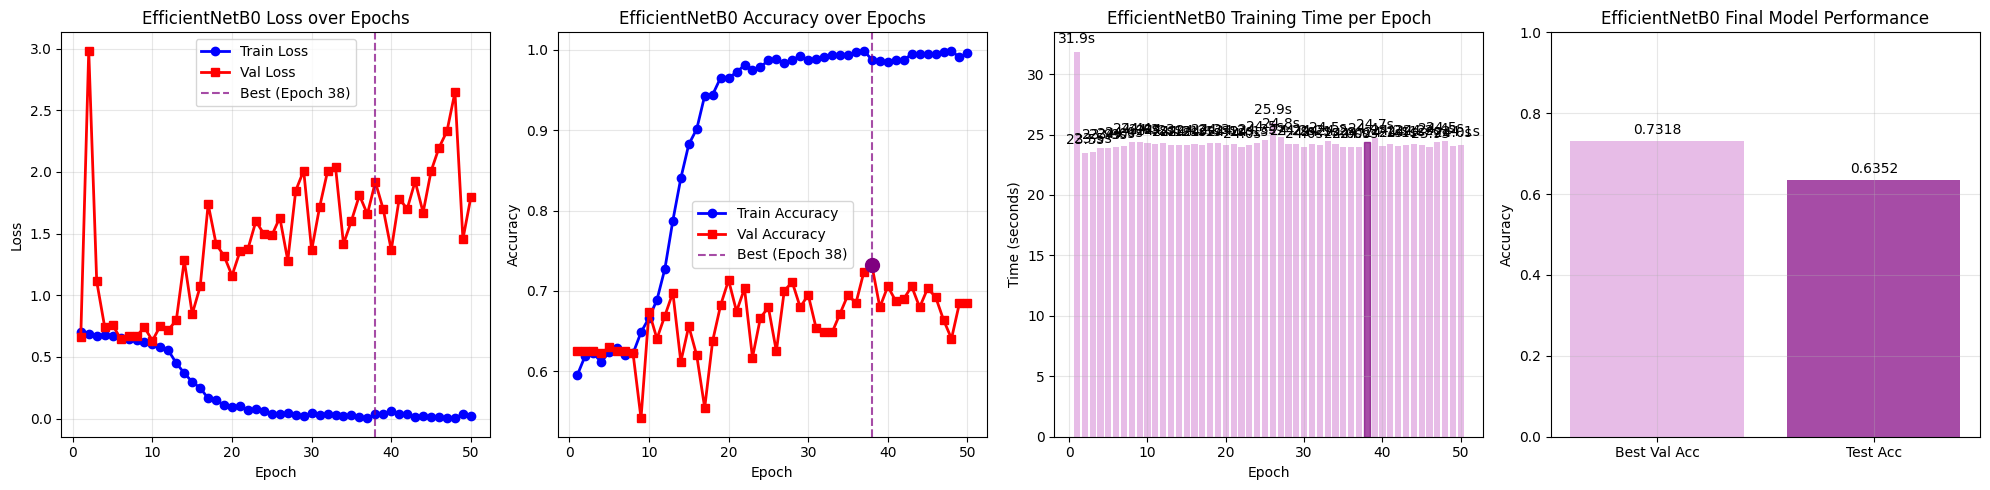


‚è∞ EfficientNetB0 Final Timing Summary:
‚îÇ Total Training: 1217.78s
‚îÇ Average per Epoch: 24.36s
‚îÇ Testing Time: 5.86s
‚îÇ Total Runtime: 1223.64s

üíæ EfficientNetB0 Files saved:
‚îÇ best_efficientnetb0_model.pth - Best validation accuracy model
‚îÇ efficientnetb0_training_history.csv - Training metrics for later plotting

üèóÔ∏è  EfficientNetB0 Architecture Summary:
‚îÇ Total Parameters: 4,010,110
‚îÇ Trainable Parameters: 4,010,110
‚îÇ Model Size: 15.30 MB
‚îÇ Input Size: 224x224x3
‚îÇ Output Classes: 2
‚îÇ Width Coefficient: 1.0
‚îÇ Depth Coefficient: 1.0
‚îÇ Dropout Rate: 0.2
‚îÇ Drop Connect Rate: 0.2
‚îÇ MBConv Blocks: 16
‚îÇ Squeeze-and-Excitation: Yes
‚îÇ Swish Activation: Yes
‚îÇ Stochastic Depth: Yes


In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torchsummary import summary
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd
from tqdm import tqdm
import time
# -----------------------------
# 4. Training Loop with Best Model Saving (Val Accuracy) - EfficientNetB0
# -----------------------------
train_losses, val_losses = [], []
train_accs, val_accs = [], []
epoch_times = []
epochs = 50

# Initialize best model tracking
best_val_acc = 0.0
best_model_state = None
best_epoch = 0

print(f"\nüöÄ Starting EfficientNetB0 Training for {epochs} epochs...")
print("=" * 80)

total_start_time = time.time()

for epoch in range(epochs):
    epoch_start_time = time.time()
    
    print(f"\nüìà Epoch {epoch+1}/{epochs}")
    print("-" * 50)
    
    # Training Phase
    print("üîÑ Training Phase...")
    model.train()
    running_loss, correct, total = 0, 0, 0
    
    train_pbar = tqdm(train_loader, desc=f"Training", 
                     bar_format='{l_bar}{bar:30}{r_bar}{bar:-30b}')
    
    train_phase_start = time.time()
    
    for batch_idx, (imgs, labels) in enumerate(train_pbar):
        imgs, labels = imgs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        
        current_acc = correct / total
        train_pbar.set_postfix({
            'Loss': f'{running_loss/(batch_idx+1):.4f}',
            'Acc': f'{current_acc:.4f}'
        })
        
        if device.type == 'cuda' and batch_idx % 10 == 0:
            gpu_memory = torch.cuda.memory_allocated() / 1024**3
            train_pbar.set_postfix({
                'Loss': f'{running_loss/(batch_idx+1):.4f}',
                'Acc': f'{current_acc:.4f}',
                'GPU': f'{gpu_memory:.1f}GB'
            })
    
    train_phase_time = time.time() - train_phase_start
    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    print(f"‚úÖ Training completed in {train_phase_time:.2f}s")
    
    # Validation Phase
    print("üîç Validation Phase...")
    model.eval()
    running_loss, correct, total = 0, 0, 0
    
    val_phase_start = time.time()
    val_pbar = tqdm(val_loader, desc=f"Validation", 
                   bar_format='{l_bar}{bar:30}{r_bar}{bar:-30b}')
    
    with torch.no_grad():
        for batch_idx, (imgs, labels) in enumerate(val_pbar):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            
            current_acc = correct / total
            val_pbar.set_postfix({
                'Loss': f'{running_loss/(batch_idx+1):.4f}',
                'Acc': f'{current_acc:.4f}'
            })
    
    val_phase_time = time.time() - val_phase_start
    val_loss = running_loss / len(val_loader)
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    print(f"‚úÖ Validation completed in {val_phase_time:.2f}s")
    
    # Check if this is the best model so far based on val_acc
    is_best = val_acc > best_val_acc
    if is_best:
        best_val_acc = val_acc
        best_epoch = epoch + 1
        best_model_state = model.state_dict().copy()
        print(f"üåü New best EfficientNetB0 model found! Validation Accuracy: {val_acc:.4f}")
    
    # Epoch Summary
    epoch_time = time.time() - epoch_start_time
    epoch_times.append(epoch_time)
    
    print(f"\nüìä Epoch {epoch+1} Summary:")
    print(f"‚îÇ Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"‚îÇ Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")
    print(f"‚îÇ Train Time: {train_phase_time:.2f}s | Val Time: {val_phase_time:.2f}s")
    print(f"‚îÇ Total Epoch Time: {epoch_time:.2f}s")
    print(f"‚îÇ Best Val Acc: {best_val_acc:.4f} (Epoch {best_epoch})")
    
    if device.type == 'cuda':
        print(f"‚îÇ GPU Memory: {torch.cuda.memory_allocated()/1024**3:.1f}GB / {torch.cuda.memory_reserved()/1024**3:.1f}GB")
    
    print("=" * 80)

total_training_time = time.time() - total_start_time

# Save the best model
if best_model_state is not None:
    torch.save(best_model_state, 'best_efficientnetb0_model.pth')
    print(f"\nüíæ Best EfficientNetB0 model saved as 'best_efficientnetb0_model.pth'")
    print(f"üìä Best model stats:")
    print(f"‚îÇ Best Epoch: {best_epoch}")
    print(f"‚îÇ Best Val Acc: {best_val_acc:.4f}")

# Save training history data to CSV
history_data = {
    'epoch': list(range(1, epochs+1)),
    'train_loss': train_losses,
    'val_loss': val_losses,
    'train_acc': train_accs,
    'val_acc': val_accs,
    'epoch_time': epoch_times
}
history_df = pd.DataFrame(history_data)
history_df.to_csv('efficientnetb0_training_history.csv', index=False)
print("\nüíæ EfficientNetB0 training history saved to 'efficientnetb0_training_history.csv'")

# Training Summary
print(f"\nüéâ EfficientNetB0 Training Complete!")
print(f"Total Training Time: {total_training_time:.2f}s ({total_training_time/60:.1f} minutes)")
print(f"Average Epoch Time: {np.mean(epoch_times):.2f}s")
print("\n‚è±Ô∏è  Epoch Timing Breakdown:")
for i, t in enumerate(epoch_times):
    print(f"‚îÇ Epoch {i+1}: {t:.2f}s")

# -----------------------------
# 5. Load Best Model and Test
# -----------------------------
print(f"\nüß™ Loading Best EfficientNetB0 Model for Testing...")

# Load the best model state
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"‚úÖ Best EfficientNetB0 model from epoch {best_epoch} loaded successfully!")
else:
    print("‚ö†Ô∏è  No best model found, using current model state")

test_start_time = time.time()
y_true, y_pred = [], []
model.eval()

test_pbar = tqdm(test_loader, desc="Testing EfficientNetB0", 
                bar_format='{l_bar}{bar:30}{r_bar}{bar:-30b}')

with torch.no_grad():
    for imgs, labels in test_pbar:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

test_time = time.time() - test_start_time
test_accuracy = accuracy_score(y_true, y_pred)

print(f"‚úÖ EfficientNetB0 Testing completed in {test_time:.2f}s")
print("\nüìã EfficientNetB0 Classification Report:")
print(classification_report(y_true, y_pred, target_names=classes))
print(f"üéØ EfficientNetB0 Test Accuracy: {test_accuracy:.4f}")

# Model Performance Summary
print(f"\nüìä EfficientNetB0 Model Performance Summary:")
print(f"‚îÇ Best Validation Acc:  {best_val_acc:.4f} (Epoch {best_epoch})")
print(f"‚îÇ Final Test Accuracy:  {test_accuracy:.4f}")
print(f"‚îÇ Val-Test Gap:         {abs(best_val_acc - test_accuracy):.4f}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"EfficientNetB0 Confusion Matrix - Best Model (Epoch {best_epoch})")
plt.show()

# -----------------------------
# 6. Enhanced Visualizations
# -----------------------------
plt.figure(figsize=(20, 5))

# Loss Plot
plt.subplot(1, 4, 1)
plt.plot(range(1, epochs+1), train_losses, 'b-', label="Train Loss", marker='o', linewidth=2)
plt.plot(range(1, epochs+1), val_losses, 'r-', label="Val Loss", marker='s', linewidth=2)
plt.axvline(x=best_epoch, color='purple', linestyle='--', alpha=0.7, label=f'Best (Epoch {best_epoch})')
plt.legend()
plt.title("EfficientNetB0 Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True, alpha=0.3)

# Accuracy Plot
plt.subplot(1, 4, 2)
plt.plot(range(1, epochs+1), train_accs, 'b-', label="Train Accuracy", marker='o', linewidth=2)
plt.plot(range(1, epochs+1), val_accs, 'r-', label="Val Accuracy", marker='s', linewidth=2)
plt.axvline(x=best_epoch, color='purple', linestyle='--', alpha=0.7, label=f'Best (Epoch {best_epoch})')
plt.scatter([best_epoch], [best_val_acc], color='purple', s=100, zorder=5)
plt.legend()
plt.title("EfficientNetB0 Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True, alpha=0.3)

# Timing Plot
plt.subplot(1, 4, 3)
bars = plt.bar(range(1, epochs+1), epoch_times, color='plum', alpha=0.7)
bars[best_epoch-1].set_color('purple')
plt.title("EfficientNetB0 Training Time per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Time (seconds)")
plt.grid(True, alpha=0.3)
for i, t in enumerate(epoch_times):
    plt.text(i+1, t+0.5, f'{t:.1f}s', ha='center', va='bottom')

# Performance Comparison
plt.subplot(1, 4, 4)
metrics = ['Best Val Acc', 'Test Acc']
values = [best_val_acc, test_accuracy]
colors = ['plum', 'purple']
bars = plt.bar(metrics, values, color=colors, alpha=0.7)
plt.title("EfficientNetB0 Final Model Performance")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.grid(True, alpha=0.3)
for bar, val in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.01, 
             f'{val:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

print(f"\n‚è∞ EfficientNetB0 Final Timing Summary:")
print(f"‚îÇ Total Training: {total_training_time:.2f}s")
print(f"‚îÇ Average per Epoch: {np.mean(epoch_times):.2f}s")
print(f"‚îÇ Testing Time: {test_time:.2f}s")
print(f"‚îÇ Total Runtime: {total_training_time + test_time:.2f}s")

print(f"\nüíæ EfficientNetB0 Files saved:")
print(f"‚îÇ best_efficientnetb0_model.pth - Best validation accuracy model")
print(f"‚îÇ efficientnetb0_training_history.csv - Training metrics for later plotting")

# -----------------------------
# 7. EfficientNetB0 Architecture Summary
# -----------------------------
print(f"\nüèóÔ∏è  EfficientNetB0 Architecture Summary:")
print(f"‚îÇ Total Parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"‚îÇ Trainable Parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
print(f"‚îÇ Model Size: {sum(p.numel() * p.element_size() for p in model.parameters()) / 1024**2:.2f} MB")
print(f"‚îÇ Input Size: 224x224x3")
print(f"‚îÇ Output Classes: {len(classes)}")
print(f"‚îÇ Width Coefficient: 1.0")
print(f"‚îÇ Depth Coefficient: 1.0")
print(f"‚îÇ Dropout Rate: 0.2")
print(f"‚îÇ Drop Connect Rate: 0.2")
print(f"‚îÇ MBConv Blocks: {len(model.blocks)}")
print(f"‚îÇ Squeeze-and-Excitation: Yes")
print(f"‚îÇ Swish Activation: Yes")
print(f"‚îÇ Stochastic Depth: Yes")